In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import time
import glob
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.axisartist.axislines import AxesZero

from dca.methods_comparison import JPCA
from pyuoi.linear_model.var  import VAR
from neurosim.models.var import form_companion

sys.path.append('/home/akumar/nse/neural_control')
from utils import apply_df_filters, calc_loadings, calc_cascaded_loadings
from loaders import load_sabes
from decoders import lr_decoder
from segmentation import reach_segment_sabes, measure_straight_dev


/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Debugging why the single unit PI is lower for the top FCCA neurons than the top PCA neurons, given that the overall trend seems to be a strong anticorrelation

In [4]:
#dframe = '/home/akumar/nse/neural_control/data/indy_decoding_df2.dat'
dframe = '/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat'

with open(dframe, 'rb') as f:
    sabes_df = pickle.load(f)
# with open('/home/akumar/nse/neural_control/data/sabes_decoding_df.dat', 'rb') as f:
#     sabes_df = pickle.load(f)

sabes_df = pd.DataFrame(sabes_df)

DIM = 6

# Try the raw leverage scores instead
loadings_l = []
data_files = np.unique(sabes_df['data_file'].values)
for i, data_file in tqdm(enumerate(data_files)):
    loadings = []
    for dimreduc_method in ['LQGCA', 'PCA']:
        loadings_fold = []
        for fold_idx in range(5):  
            df_ = apply_df_filters(sabes_df, data_file=data_file, fold_idx=fold_idx, dim=DIM, dimreduc_method=dimreduc_method)
            if dimreduc_method == 'LQGCA':
                df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 10})
            V = df_.iloc[0]['coef']
            if dimreduc_method == 'PCA':
                V = V[:, 0:DIM]        
            loadings_fold.append(calc_loadings(V))


        # Average loadings across folds
        loadings.append(np.mean(np.array(loadings_fold), axis=0))

    for j in range(loadings[0].size):
        d_ = {}
        d_['data_file'] = data_file
        d_['FCCA_loadings'] = loadings[0][j]
        d_['PCA_loadings'] = loadings[1][j]
        # d_['DCA_loadings'] = loadings[2][j]
        d_['nidx'] = j
        loadings_l.append(d_)                

loadings_df = pd.DataFrame(loadings_l)

# For each data file, find the top 5 neurons that are high in one method but low in all others
top_neurons_l = []
n = 10
for i, data_file in tqdm(enumerate(data_files)):
    df_ = apply_df_filters(loadings_df, data_file=data_file)
    # DCA_ordering = np.argsort(df_['DCA_loadings'].values)
    # KCA_ordering = np.argsort(df_['KCA_loadings'].values)
    FCCA_ordering = np.argsort(df_['FCCA_loadings'].values)
    PCA_ordering = np.argsort(df_['PCA_loadings'].values)
    
    rank_diffs = np.zeros((FCCA_ordering.size, 1))
    for j in range(df_.shape[0]):
        rank_diffs[j, 0] = list(FCCA_ordering).index(j) - list(PCA_ordering).index(j)

    # Find the top 5 neurons according to all pairwise high/low orderings
    top_neurons = np.zeros((2, n)).astype(int)

    # DCA_top = set([])
    # KCA_top = set([])
    FCCA_top = []
    PCA_top = []

    # Also include the leverage scores associated with the top neurons
    FCCA_top_ls = []
    PCA_top_ls = []

    idx = 0
    while not np.all([len(x) >= n for x in [FCCA_top, PCA_top]]):
        idx += 1
        # Take neurons from the top ordering of each method. Disregard neurons that 
        # show up in all methods
        # top_DCA = DCA_ordering[-idx]
        top_FCCA = FCCA_ordering[-idx]
        top_PCA = PCA_ordering[-idx]

        if top_FCCA != top_PCA:
            if top_FCCA not in PCA_top:
                FCCA_top.append(top_FCCA)
                FCCA_top_ls.append(df_['FCCA_loadings'].values[top_FCCA])
            if top_PCA not in FCCA_top:
                PCA_top.append(top_PCA)
                PCA_top_ls.append(df_['PCA_loadings'].values[top_PCA])
        else:
            continue

    top_neurons[0, :] = FCCA_top[0:n]
    top_neurons[1, :] = PCA_top[0:n] 
    top_neurons_l.append({'data_file':data_file, 'rank_diffs':rank_diffs, 'top_neurons': top_neurons, 'FCCA_l':FCCA_top_ls, 'PCA_l':PCA_top_ls}) 

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
28it [00:00, 47.49it/s]
28it [00:00, 514.90it/s]


In [5]:
top_neurons_df = pd.DataFrame(top_neurons_l)

In [6]:
from dca.cov_util import calc_cross_cov_mats_from_data, calc_pi_from_cross_cov_mats, calc_pi_from_data, calc_cov_from_cross_cov_mats, calc_pi_from_cov

In [21]:
def single_unit_PI(top_neurons_df):

    data_path = '/mnt/Secondary/data/sabes'
    data_files = np.unique(top_neurons_df['data_file'].values)

    PI = np.zeros((len(data_files), 2, n, 2))
    ls = np.zeros((len(data_files), 2, n, 2))

    for h, data_file in enumerate(data_files):
        df_ = apply_df_filters(top_neurons_df, data_file=data_file)
        dat = load_sabes('%s/%s' % (data_path, data_file), boxcox=0.5, high_pass=True)
        x = dat['spike_rates'].squeeze()
        ccm = calc_cross_cov_mats_from_data(x, 10)

        for i in range(2):
            for j in range(n):
                tn = df_.iloc[0]['top_neurons'][i, j]    
                pi = calc_pi_from_cross_cov_mats(ccm[:, tn, tn][:, np.newaxis, np.newaxis])
                PI[h, i, j, 0] = pi
                pi = calc_pi_from_cross_cov_mats(ccm[0:9, tn, tn][:, np.newaxis, np.newaxis])
                PI[h, i, j, 1] = pi

                if i == 0:
                    ls[h, i, j] = df_.iloc[0]['FCCA_l'][j]
                else:
                    ls[h, i, j] = df_.iloc[0]['PCA_l'][j]
    return PI, ls


In [22]:
PI, ls = single_unit_PI(top_neurons_df)

In [23]:
# Scatter PI vs. FCCA leverage scores and PI vs. PCA leverage scores

In [26]:
ls.shape

(28, 2, 10, 2)

In [25]:
PI.shape

(28, 2, 10, 2)

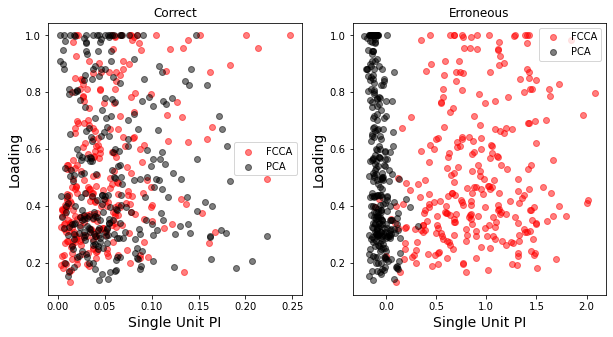

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(PI[:, 0, :, 0].ravel(), ls[:, 0, :, 0].ravel(), color='r', alpha=0.5)
ax[0].scatter(PI[:, 1, :, 0].ravel(), ls[:, 1, :, 0].ravel(), color='k', alpha=0.5)
ax[0].legend(['FCCA', 'PCA'])
ax[0].set_xlabel('Single Unit PI', fontsize=14)
ax[0].set_ylabel('Loading', fontsize=14)
ax[0].set_title('Correct')

ax[1].scatter(PI[:, 0, :, 1].ravel(), ls[:, 0, :, 1].ravel(), color='r', alpha=0.5)
ax[1].scatter(PI[:, 1, :, 1].ravel(), ls[:, 1, :, 1].ravel(), color='k', alpha=0.5)
ax[1].legend(['FCCA', 'PCA'])
ax[1].set_xlabel('Single Unit PI', fontsize=14)
ax[1].set_ylabel('Loading', fontsize=14)
ax[1].set_title('Erroneous')

fig.savefig('/home/akumar/nse/neural_control/figs/su_pi_debugging/top_neurons.pdf', bbox_inches='tight', pad_inches=0)

In [65]:
# Now, just plot the scattering of single unit PI vs. the leverage scores across the entire dataset. Point is to verify the very strong anti-correlation between variance and single unit PI

data_path = '/mnt/Secondary/data/sabes'
data_files = np.unique(top_neurons_df['data_file'].values)

PI = []
ls_all = []

T = np.array([2, 3, 4, 5])

for h, data_file in tqdm(enumerate(data_files)):
    df_ = apply_df_filters(loadings_df, data_file=data_file)
    dat = load_sabes('%s/%s' % (data_path, data_file), boxcox=0.5, high_pass=True)
    x = dat['spike_rates'].squeeze()
    # ccm = calc_cross_cov_mats_from_data(x, 10)

    n = x.shape[-1]
    pi = np.zeros((x.shape[-1], T.size))
    ls = np.zeros((2, x.shape[-1]))

    for j in range(n):
        for k, t in enumerate(T):
            #supi = calc_pi_from_cross_cov_mats(ccm[0:t, j, j][:, np.newaxis, np.newaxis])
            supi = calc_pi_from_data(x[:, j][:, np.newaxis], T=t)
            pi[j, k] = supi
        ls[0, j] = df_['FCCA_loadings'].values[j]
        ls[1, j] = df_['PCA_loadings'].values[j]

    PI.append(pi)
    ls_all.append(ls)

28it [03:29,  7.49s/it]


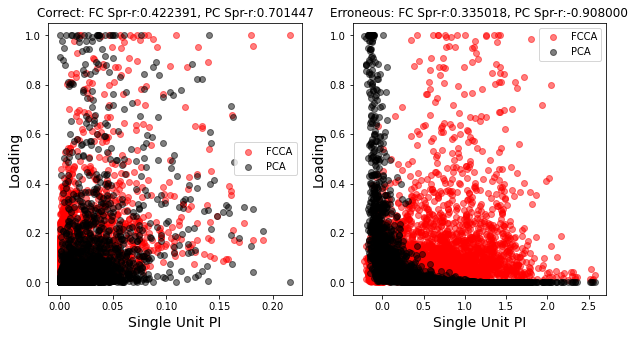

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

x1 = []
y1 = []
idx = 2
for h in range(28):
    x1.extend(PI[h][:, idx])
    y1.extend(ls_all[h][0, :])

x2 = []
y2 = []
for h in range(28):
    x2.extend(PI[h][:, idx])
    y2.extend(ls_all[h][1, :])

spr1 = scipy.stats.spearmanr(x1, y1)[0]
spr2 = scipy.stats.spearmanr(x2, y2)[0]


ax[0].scatter(x1, y1, color='r', alpha=0.5)
ax[0].scatter(x2, y2, color='k', alpha=0.5)
ax[0].legend(['FCCA', 'PCA'])
ax[0].set_xlabel('Single Unit PI', fontsize=14)
ax[0].set_ylabel('Loading', fontsize=14)
ax[0].set_title('Correct: FC Spr-r:%2f, PC Spr-r:%2f' % (spr1, spr2))

x3 = []
y3 = []
idx = 3
for h in range(28):
    x3.extend(PI[h][:, idx])
    y3.extend(ls_all[h][0, :])

x4 = []
y4 = []
for h in range(28):
    x4.extend(PI[h][:, idx])
    y4.extend(ls_all[h][1, :])

spr1 = scipy.stats.spearmanr(x3, y3)[0]
spr2 = scipy.stats.spearmanr(x4, y4)[0]

ax[1].scatter(x3, y3, color='r', alpha=0.5)
ax[1].scatter(x4, y4, color='k', alpha=0.5)
ax[1].legend(['FCCA', 'PCA'])
ax[1].set_xlabel('Single Unit PI', fontsize=14)
ax[1].set_ylabel('Loading', fontsize=14)
ax[1].set_title('Erroneous: FC Spr-r:%2f, PC Spr-r:%2f' % (spr1, spr2))

fig.savefig('/home/akumar/nse/neural_control/figs/su_pi_debugging/all_neurons.pdf', bbox_inches='tight', pad_inches=0)

In [48]:
scipy.stats.spearmanr(x2, y2)

SpearmanrResult(correlation=0.701447259183502, pvalue=0.0)

In [49]:
scipy.stats.spearmanr(x1, y1)

SpearmanrResult(correlation=0.422391166213683, pvalue=1.7769573113808465e-167)

The crucial lesson is that one must be very careful with the T values used in dca cov_util functions

In [35]:
# Next: Attempt to explain results using single unit autocorrelation times

In [51]:
1/np.e**2

0.1353352832366127

In [7]:
# Now, just plot the scattering of single unit PI vs. the leverage scores across the entire dataset. Point is to verify the very strong anti-correlation between variance and single unit PI

data_path = '/mnt/Secondary/data/sabes'
data_files = np.unique(top_neurons_df['data_file'].values)

ACOV = []
ls_all = []

thresh = [1e-1, 5e-2]

for h, data_file in tqdm(enumerate(data_files)):
    df_ = apply_df_filters(loadings_df, data_file=data_file)
    dat = load_sabes('%s/%s' % (data_path, data_file), boxcox=0.5, high_pass=True)
    x = dat['spike_rates'].squeeze()
    ccm = calc_cross_cov_mats_from_data(x, 20)

    n = x.shape[-1]
    acovtimes = np.zeros((x.shape[-1], 2))
    ls = np.zeros((2, x.shape[-1]))

    for j in range(n):
        for k, thr in enumerate(thresh):
            ccm_j = ccm[:, j, j]
            ccm_j /= ccm_j[0]
            acov_crossing = np.where(ccm_j < thr)
            if len(acov_crossing[0]) > 0:
                acovtimes[j, k] = np.where(ccm_j < thr)[0][0]
            else:
                acovtimes[j, k] = 20

        ls[0, j] = df_['FCCA_loadings'].values[j]
        ls[1, j] = df_['PCA_loadings'].values[j]

    ACOV.append(acovtimes)
    ls_all.append(ls)

28it [02:55,  6.26s/it]


NameError: name 'PI' is not defined

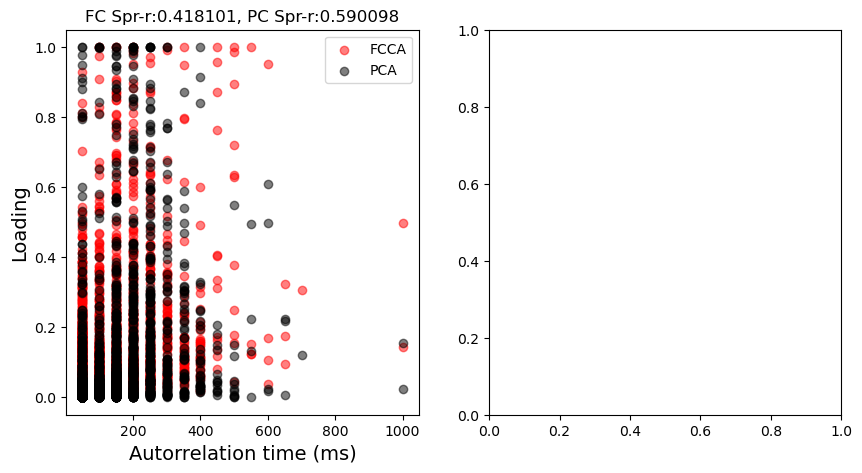

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

x1 = []
y1 = []
for h in range(28):
    x1.extend(ACOV[h][:, 0])
    y1.extend(ls_all[h][0, :])

x2 = []
y2 = []
for h in range(28):
    x2.extend(ACOV[h][:, 0])
    y2.extend(ls_all[h][1, :])

spr1 = scipy.stats.spearmanr(x1, y1)[0]
spr2 = scipy.stats.spearmanr(x2, y2)[0]
ax[0].set_title('FC Spr-r:%2f, PC Spr-r:%2f' % (spr1, spr2))
ax[0].scatter(50 * np.array(x1), y1, color='r', alpha=0.5)
ax[0].scatter(50 * np.array(x2), y2, color='k', alpha=0.5)
ax[0].legend(['FCCA', 'PCA'])
ax[0].set_xlabel('Autorrelation time (ms)', fontsize=14)
ax[0].set_ylabel('Loading', fontsize=14)

x3 = []
y3 = []
for h in range(28):
    x3.extend(ACOV[h][:, 0])
    y3.extend(PI[h][:, 2])

spr1 = scipy.stats.spearmanr(x3, y3)[0]

ax[1].scatter(50 * np.array(x3), y3, color='r', alpha=0.5)
ax[1].set_xlabel('Autocorrelation time (ms)', fontsize=14)
ax[1].set_ylabel('Single Unit PI', fontsize=14)
ax[1].set_title('Autocorr, PI Spr-R: %2f' % spr1)
fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/su_pi_debugging/all_neurons_autocorrelation.pdf', bbox_inches='tight', pad_inches=0)

In [9]:
x1 = []
y1 = []
for h in range(28):
    x1.append(ACOV[h][:, 0])
    y1.append(ls_all[h][0, :])

x2 = []
y2 = []
for h in range(28):
    x2.append(ACOV[h][:, 0])
    y2.append(ls_all[h][1, :])


In [14]:
r1 = [scipy.stats.spearmanr(x_, y_)[0] for x_, y_ in zip(x1, y1)]

In [19]:
r1

[0.6098980878095178,
 0.5648520359552638,
 0.4972560199677716,
 0.608098269250508,
 0.6241999448846847,
 0.37209187373017233,
 0.3140160015950173,
 0.3415943112753217,
 0.398207829566688,
 0.36162340932480197,
 0.3843509456826915,
 0.36673531045387,
 0.3452000710403683,
 0.4331142566316324,
 0.369644987713759,
 0.41840688709281565,
 0.5141011114446244,
 0.3445162383683936,
 0.4190097552187958,
 0.3878713088358275,
 0.5389995987517391,
 0.3720727071218162,
 0.44945825159048525,
 0.5189694484349963,
 0.45778177250387087,
 0.4132967251585099,
 0.46979343457397865,
 0.48105608926482935]

In [12]:
r2 = [scipy.stats.spearmanr(x_, y_)[0] for x_, y_ in zip(x2, y2)]

In [20]:
r2

[0.3144441586555715,
 0.36373380295965924,
 0.5673886430250378,
 0.48095369477678773,
 0.5631847610655841,
 0.6151291883167129,
 0.6510107617137187,
 0.5850678473778775,
 0.5663879929214111,
 0.5897558576423148,
 0.6147500996908235,
 0.6008112590414323,
 0.6225504148269969,
 0.6456069625622834,
 0.6559060229190038,
 0.6887440694192627,
 0.6011408097390502,
 0.6972025983650348,
 0.667706854737299,
 0.5676426658904181,
 0.6713168530866115,
 0.7285117134885308,
 0.6165501397822117,
 0.5817828307513697,
 0.7365279267443712,
 0.5367469023014304,
 0.5881804734797166,
 0.6468912868312361]

In [15]:
np.mean(r1)

0.4420077386872411

In [16]:
np.mean(r2)

0.5987723782897056

In [17]:
np.std(r1)

0.08719567750311716

In [18]:
np.std(r2)

0.09147135682129476

In [71]:
scipy.stats.spearmanr(x1, y1)

SpearmanrResult(correlation=0.41810109722596644, pvalue=8.631679720980651e-164)

In [72]:
scipy.stats.spearmanr(x3, y3)

SpearmanrResult(correlation=0.8786321004708767, pvalue=0.0)

In [78]:
from dca_research.lqg import build_loss
from dca_research.lqg import LQGComponentsAnalysis as LQGCA
import torch

In [82]:
# Proposal: Instead look at single unit controllability
# Now, just plot the scattering of single unit PI vs. the leverage scores across the entire dataset. Point is to verify the very strong anti-correlation between variance and single unit PI

data_path = '/mnt/Secondary/data/sabes'
data_files = np.unique(top_neurons_df['data_file'].values)

FCC = []
ls_all = []

for h, data_file in tqdm(enumerate(data_files)):
    df_ = apply_df_filters(loadings_df, data_file=data_file)
    dat = load_sabes('%s/%s' % (data_path, data_file), boxcox=0.5, high_pass=True)
    x = dat['spike_rates'].squeeze()
    lqgmodel = LQGCA(T=3)
    lqgmodel.estimate_data_statistics(x)    
    
    n = x.shape[-1]
    sufcc = np.zeros(n)
    ls = np.zeros((2, x.shape[-1]))

    loss = build_loss(lqgmodel.cross_covs.float(), lqgmodel.cross_covs_rev.float(), 1, ortho_lambda=0)
    for j in range(n):
        V = torch.zeros((n, 1)).float()
        V[j, 0] = 1
        sufcc[j] = loss(V)
        ls[0, j] = df_['FCCA_loadings'].values[j]
        ls[1, j] = df_['PCA_loadings'].values[j]

    FCC.append(sufcc)
    ls_all.append(ls)

28it [03:21,  7.18s/it]


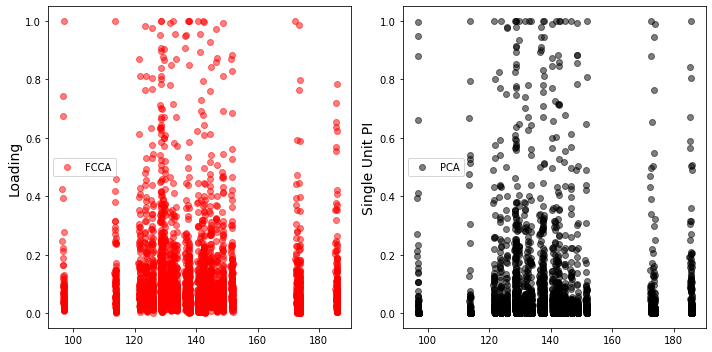

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

x1 = []
y1 = []
for h in range(28):
    x1.extend(FCC[h])
    y1.extend(ls_all[h][0, :])

x2 = []
y2 = []
for h in range(28):
    x2.extend(FCC[h])
    y2.extend(ls_all[h][1, :])

ax[0].scatter(x1, y1, color='r', alpha=0.5)
ax[0].legend(['FCCA'])
#ax[0].set_xlabel('Autorrelation time (ms)', fontsize=14)
ax[0].set_ylabel('Loading', fontsize=14)

ax[1].scatter(x2, y2, color='k', alpha=0.5)
ax[1].legend(['PCA'])
#ax[1].set_xlabel('Autocorrelation time (ms)', fontsize=14)
ax[1].set_ylabel('Single Unit PI', fontsize=14)
fig.tight_layout()
#fig.savefig('/home/akumar/nse/neural_control/figs/su_pi_debugging/all_neurons_autocorrelation.pdf', bbox_inches='tight', pad_inches=0)

In [86]:
scipy.stats.spearmanr(x2, y2)[0]

-0.09712889761939299